# An Exploratory Data Analysis on the UCI Heart Disease Dataset

This is the first part of a short analysis piece on the [Heart Disease dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) from the UCI machine learning repository. This analysis uses the cleveland dataset from the repository.


In [23]:
%matplotlib inline

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Data Wrangling

To begin, let's look at the general structure of the data:

In [25]:
filename = 'processed.cleveland.csv'
cleveland = pd.read_csv(filename)
cleveland.head()

,Age,Sex,Chest_pain_type,resting_bp,serum_chol,blood_sugar,ecg,max_hr,e_i_angina,ST_dep,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


In [26]:
cleveland.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
Age                303 non-null int64
Sex                303 non-null int64
Chest_pain_type    303 non-null int64
resting_bp         303 non-null int64
serum_chol         303 non-null int64
blood_sugar        303 non-null int64
ecg                303 non-null int64
max_hr             303 non-null int64
e_i_angina         303 non-null int64
ST_dep             303 non-null float64
slope              303 non-null int64
ca                 303 non-null object
thal               303 non-null object
num                303 non-null int64
dtypes: float64(1), int64(11), object(2)
memory usage: 33.2+ KB


There are 303 entries and 14 features. We can see that the 'ca' and 'thal' features were imported as objects. From the UCI description, ca refers to the number of major vessels coloured by fluroscopy and is continuous, and thal refers to the type of thalium defect, which is categorical. We'll have to inspect the features and change the datatype:

In [27]:
pd.value_counts(cleveland['ca'].values)

0    176
1     65
2     38
3     20
?      4
dtype: int64

4 entries have missing data for the ca feature. As there are 4 unique values, we will treat this as a categorical feature.  Taking a look at 'thal':

In [28]:
pd.value_counts(cleveland['thal'].values)

3    166
7    117
6     18
?      2
dtype: int64

2 entries have missing data. We'll replace the missing data with NaNs, before deleting the rows containing the missing values. Additionally we'll convert the continuous features from integers to floats in preparation for feature scaling and normalisation:

In [29]:
#replace missing data with NaNs
cleveland['ca'] = cleveland['ca'].replace('?', np.NaN)
cleveland['thal'] = cleveland['thal'].replace('?', np.NaN)

# Drop rows with na values
cleveland = cleveland.dropna()

# Convert datatypes: continuous features 
cleveland['Age'] = cleveland['Age'].astype("float64")
cleveland['resting_bp'] = cleveland['resting_bp'].astype("float64")
cleveland['serum_chol'] = cleveland['serum_chol'].astype("float64")
cleveland['max_hr'] = cleveland['max_hr'].astype("float64")
cleveland['ST_dep'] = cleveland['ST_dep'].astype("float64")

#Convert datatypes: categorical features 
cleveland['thal'] = cleveland['thal'].astype("int64")
cleveland['ca'] = cleveland['ca'].astype("int64")

cleveland.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
Age                297 non-null float64
Sex                297 non-null int64
Chest_pain_type    297 non-null int64
resting_bp         297 non-null float64
serum_chol         297 non-null float64
blood_sugar        297 non-null int64
ecg                297 non-null int64
max_hr             297 non-null float64
e_i_angina         297 non-null int64
ST_dep             297 non-null float64
slope              297 non-null int64
ca                 297 non-null int64
thal               297 non-null int64
num                297 non-null int64
dtypes: float64(5), int64(9)
memory usage: 34.8 KB


The datatypes all look appropriate. We can now move on to the exploratory data analysis.

## Exploratory Data Analysis 

Let's begin by looking at num, the heart disease predictor variable: 

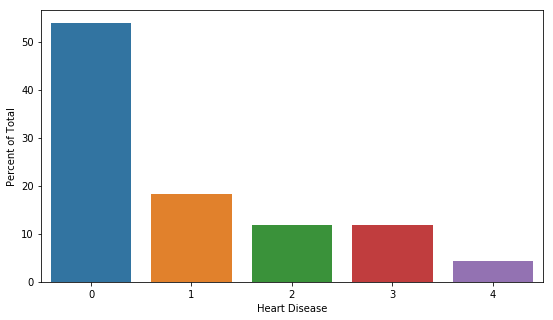

In [30]:
plt.figure(figsize = (9,5))
sns.barplot(x = 'num', y= 'num', data = cleveland, estimator = lambda x: len(x) / len(cleveland) * 100)
plt.xlabel('Heart Disease')
plt.ylabel('Percent of Total')

Just over 50% of cases are negative, with the rest of the cases being positive with differing degrees of severity. As we are dealing with very small sample sizes, accurately predicting the label of the predictor as a multiclass categorical feature is unlikely to yield results that will generalize to new data. Let's re-encode num as a binary variable, so we will predict whether heart disease is present (1) or absent (0):

In [31]:
#re-encode num as a binary variable
cleveland['num'] = (cleveland.num>0).astype("int")

#Show relative frequency of each value
pd.value_counts(cleveland['num'].values, normalize = True)

0    0.538721
1    0.461279
dtype: float64

Let's now visualise the continuous features across the new binary predictor variable:

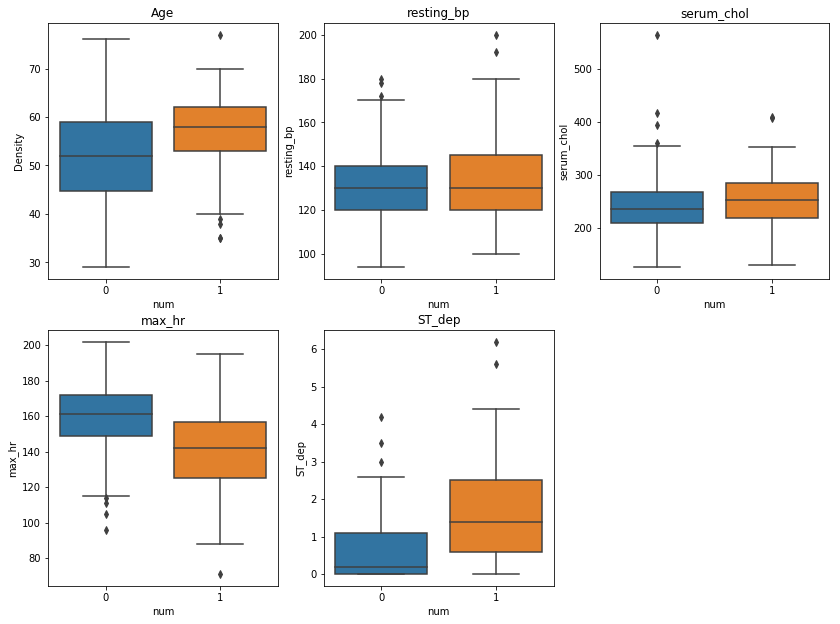

In [32]:
plt.figure(figsize=(14,16))

plt.subplot(3,3,1)
sns.boxplot(x='num', y='Age', data=cleveland)
plt.ylabel('Density')
plt.gca().set_title('Age')

plt.subplot(3,3,2)
sns.boxplot(x='num', y='resting_bp', data=cleveland)
plt.gca().set_title('resting_bp')

plt.subplot(3,3,3)
sns.boxplot(x='num', y='serum_chol', data=cleveland)
plt.gca().set_title('serum_chol')

plt.subplot(3,3,4)
sns.boxplot(x='num', y='max_hr', data=cleveland)
plt.gca().set_title('max_hr')

plt.subplot(3,3,5)
sns.boxplot(x='num', y='ST_dep', data=cleveland)
plt.gca().set_title('ST_dep')


On visual inspection, individuals in the group with heart disease are typically older, with lower maximum heart rates and more pronounced ST depression compared to those without heart disease. The differeces in resting blood pressure and serum cholesterol are less marked between the groups.

The next plot is a correlation matrix of the features, displayed as a heatmap. This allows us to check if there are any dependencies between the variables:

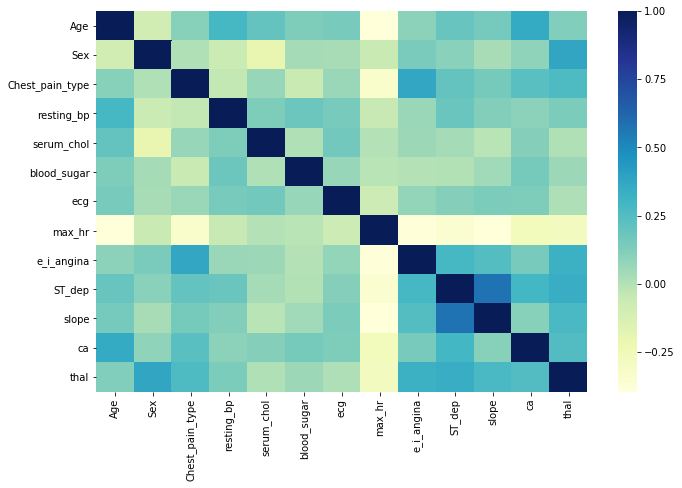

In [33]:
corr = cleveland.iloc[:,0:13].corr()
plt.figure(figsize=(11,7))
sns.heatmap(corr, cmap="YlGnBu")

There are no strong correlations between any of the variables, and based on the plot, there are no obviously redundant features. To finish, we'll save the wrangled data to a csv file in preparation for modelling:

In [34]:
cleveland.to_csv('wrangled_cleveland.csv', index = False)